# Classification using a neural network

Dataset: https://www.kaggle.com/easonlai/sample-insurance-claim-prediction-dataset?select=insurance2.csv

In [40]:
import jax
import pandas as pd
import matplotlib.pyplot as plt
import jax.numpy as jnp

from jax import grad, jit, random
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [1]:
from google.colab import drive 

drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
insurance_claim_data = pd.read_csv('/content/drive/MyDrive/jax_datasets/insurance_data.csv')

insurance_claim_data.head()

,age,sex,bmi,children,smoker,region,insuranceclaim,charges
0,19,1,27.900,0,1,3,1,16884.92400
1,18,0,33.770,1,0,2,1,1725.55230
2,28,0,33.000,3,0,2,0,4449.46200
3,33,0,22.705,0,0,1,0,21984.47061
4,32,0,28.880,0,0,1,1,3866.85520


Target balance is checked. Dataset is quite balanced

In [6]:
insurance_claim_data['insuranceclaim'].value_counts()

1    783
0    555
Name: insuranceclaim, dtype: int64

Separate predictor and target dataframes are created

In [7]:
X = insurance_claim_data.drop('insuranceclaim', axis = 1)

y = insurance_claim_data['insuranceclaim']

Data is split into Train(0.7) and Test set(0.3)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, 
                                                    stratify = y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((936, 7), (402, 7), (936,), (402,))

Dataframes containing only numerical columns are separated out for scaling

In [9]:
X_train_numerical = X_train[['age', 'bmi','children','charges']]

X_test_numerical = X_test[['age', 'bmi','children','charges']]

Dataframes containing only categorical columns are separated out to avoid scaling. Note that feature 'region' is dropped to avoid one hot encoding of this feature(only for reducing preprocessing steps).In the dataframe, this feature is ordinally encoded(should be one hot encoded).

In [10]:
X_train_categorical = X_train[['sex', 'smoker']]

X_test_categorical = X_test[['sex', 'smoker']]

Training and testing numeric predictor dataframes are scaled

In [11]:
scaler = StandardScaler()

X_train_numerical = pd.DataFrame(scaler.fit_transform(X_train_numerical), 
                                 columns = X_train_numerical.columns)

X_test_numerical = pd.DataFrame(scaler.transform(X_test_numerical),
                                columns = X_test_numerical.columns)

In [13]:
X_train_categorical.reset_index(drop = True, inplace = True)
X_train_numerical.reset_index(drop = True, inplace = True)

X_train = pd.concat([X_train_categorical, X_train_numerical], axis = 1)

X_train.head()

,sex,smoker,age,bmi,children,charges
0,1,1,1.655873,-0.611119,-0.895933,1.347079
1,0,0,-1.184197,3.231165,-0.076194,-0.901567
2,1,0,-1.539206,1.388839,-0.895933,-0.969844
3,1,0,1.513870,-1.578259,-0.895933,0.029444
4,1,1,1.726875,-0.626718,-0.895933,1.379353


Finally categorical columns are merged with scaled numeric columns using corresponding dataframes for both Training and Testing sets

In [14]:
X_test_categorical.reset_index(drop = True, inplace = True)
X_test_numerical.reset_index(drop = True, inplace = True)

X_test = pd.concat([X_test_categorical, X_test_numerical], axis = 1)

X_test.head()

,sex,smoker,age,bmi,children,charges
0,1,0,0.874854,1.099847,-0.895933,-0.291199
1,1,1,-1.468204,0.656506,0.743546,1.978705
2,0,1,0.519845,1.352715,0.743546,2.640691
3,1,0,-0.403178,-0.652169,-0.076194,-0.684040
4,0,0,0.022833,0.558807,-0.076194,-0.548555


In [15]:
X_train, X_test, y_train, y_test = jnp.array(X_train.to_numpy(), dtype = jnp.float32),\
                                   jnp.array(X_test.to_numpy(), dtype = jnp.float32),\
                                   jnp.array(y_train.to_numpy(), dtype = jnp.float32),\
                                   jnp.array(y_test.to_numpy(), dtype = jnp.float32)

In [111]:
n_features = X_train.shape[1]

def initialize_params(layer_sizes):
  params = []

  for n_in, n_out in zip(layer_sizes[:-1], layer_sizes[1:]):
    params.append(dict(
        weights = random.normal(key = random.PRNGKey(111), shape = (n_in, n_out)) * jnp.sqrt(2/n_in),
        biases = jnp.ones(shape = (n_out, ))
      )
    )
  return params

params = initialize_params([n_features, 8, 16, 1])

The shapes of our parameters(layer-wise) are checked using tree_map

In [112]:
jax.tree_map(lambda x: x.shape, params)

[{'biases': (8,), 'weights': (6, 8)},
 {'biases': (16,), 'weights': (8, 16)},
 {'biases': (1,), 'weights': (16, 1)}]

Loss function is negative log loss (binary cross entropy loss).

For hidden layers, RELU actiavtion is applied. Only For last layer,Sigmoid activation is applied.

Bounding the probabilities within (0,1) to avoid ln(0) using clip in loss function definition.

In [114]:
def predict_y(params, X, activation = lambda x: x):
    
    *hidden, last = params
    
    for layer in hidden:
      X = jax.nn.relu(jnp.matmul(X, layer['weights']) + layer['biases'])

    return activation(jnp.matmul(X, last['weights']) + last['biases']).squeeze()


def loss_fn(params, X, y, eps = 1e-14):
    p = predict_y(params, X, jax.nn.sigmoid)
    p = jnp.clip(p, eps, 1 - eps)

    error = -(y * jnp.log(p) + (1 - y) * jnp.log(1 - p))

    return jnp.mean(error)

Function for updating parameters (using tree_map) are defined. 

In [115]:
def update(params, X, y, lr):

  grads = jax.grad(loss_fn)(params, X, y)

  return jax.tree_map(
      lambda p, g: p - lr * g, params, grads
  )

The training loop is started.Note that we are jitting the update parameters function for faster execution

In [116]:
loss_history = []

for i in range(10000):
    loss = loss_fn(params, X_train, y_train, eps = 1e-14)

    if (i + 1) % 500 == 0:
      print('Iteration', i + 1, 'Loss:', loss)

    loss_history.append(loss)

    params = jit(update)(params, X_train, y_train, lr = 0.001)

Iteration 500 Loss: 0.5723114
Iteration 1000 Loss: 0.5130784
Iteration 1500 Loss: 0.4780112
Iteration 2000 Loss: 0.45291576
Iteration 2500 Loss: 0.43352214
Iteration 3000 Loss: 0.41750625
Iteration 3500 Loss: 0.40351832
Iteration 4000 Loss: 0.39146635
Iteration 4500 Loss: 0.38108984
Iteration 5000 Loss: 0.3719359
Iteration 5500 Loss: 0.3637844
Iteration 6000 Loss: 0.3564156
Iteration 6500 Loss: 0.34971622
Iteration 7000 Loss: 0.34370378
Iteration 7500 Loss: 0.338142
Iteration 8000 Loss: 0.33292326
Iteration 8500 Loss: 0.32811627
Iteration 9000 Loss: 0.32364443
Iteration 9500 Loss: 0.31945953
Iteration 10000 Loss: 0.31548342


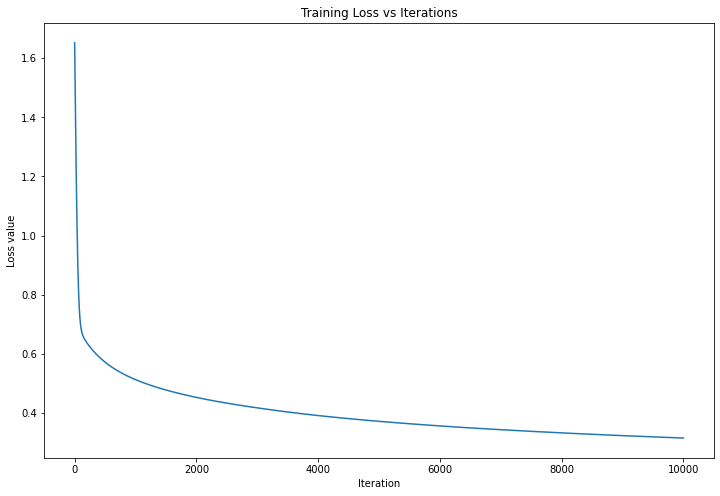

In [117]:
_, ax = plt.subplots(figsize = (12, 8))

ax.set(xlabel = 'Iteration', ylabel = 'Loss value', title = 'Training Loss vs Iterations')

plt.plot(loss_history)

Predict probabilities values are obtained for testing set

In [118]:
y_pred_proba = predict_y(params, X_test, jax.nn.sigmoid)

y_pred_proba[:5]

DeviceArray([0.99143374, 0.834376  , 0.9207733 , 0.09695256, 0.8014716 ],            dtype=float32)

Prediction on test data is done.Classification report containing accuracy metrics with initial values of parameters

In [119]:
y_pred = jnp.array(y_pred_proba)
y_pred = jnp.where(y_pred < 0.5, 0., 1.0)

print(y_pred[:5])

print(accuracy_score(y_test, y_pred))

[1. 1. 1. 0. 1.]
0.8606965174129353
